<a href="https://colab.research.google.com/github/mariamfarghali/MachineLearning-Project/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1: Upload kaggle.json
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file (download from Kaggle account)

# Step 2: Configure Kaggle API
!mkdir -p ~/.kaggle  # Create the .kaggle directory
!cp kaggle.json ~/.kaggle/  # Copy the kaggle.json file to the directory
!chmod 600 ~/.kaggle/kaggle.json  # Set the required permissions

# Step 3: Download the dataset from Kaggle
!kaggle datasets download -d jessicali9530/lfw-dataset  # Download the dataset

# Step 4: Unzip the dataset
!unzip lfw-dataset.zip -d ./lfw-dataset  # Unzip the dataset to a new folder

# Step 5: Verify the dataset contents
!ls ./lfw-dataset  # List the contents of the dataset folder


Streaming output truncated to the last 5000 lines.
  inflating: ./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: ./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: ./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: ./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: ./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: ./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0030.jpg  
  inflating: ./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0031.jpg  
  inflating: ./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_

In [3]:
import os
# List contents of the dataset folder
dataset_path = '/content/lfw-dataset'
print(os.listdir(dataset_path))

['pairs.csv', 'people.csv', 'matchpairsDevTest.csv', 'mismatchpairsDevTest.csv', 'lfw_readme.csv', 'mismatchpairsDevTrain.csv', 'matchpairsDevTrain.csv', 'lfw-deepfunneled', 'lfw_allnames.csv', 'peopleDevTrain.csv', 'peopleDevTest.csv']


In [4]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, Conv2D, MaxPooling2D, Flatten, Layer

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
base_path = '/content/drive/MyDrive/data'

In [9]:
# paths fro data
pos_path = os.path.join(base_path, 'positive')
neg_path = os.path.join(base_path, 'negative')
anc_path = os.path.join(base_path, 'anchor')


In [10]:
os.makedirs(pos_path, exist_ok=True)
os.makedirs(neg_path, exist_ok=True)
os.makedirs(anc_path, exist_ok=True)


In [11]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices ('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth (gpu, True)

In [12]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [13]:
import os

# The directory you want to create
pos_path = '/content/drive/MyDrive/data/positive'
neg_path = '/content/drive/MyDrive/data/negative'
anc_path = '/content/drive/MyDrive/data/anchor'

# Create the directory
os.makedirs(pos_path, exist_ok=True)
os.makedirs(neg_path, exist_ok=True)
os.makedirs(anc_path, exist_ok=True)

In [ ]:
# import os
# import shutil
# # Mount Google Drive first as shown above
# neg_path = '/content/drive/MyDrive/data/negative'
# lfw_path = '/content/lfw-dataset/lfw-deepfunneled'  # Update this path

# for directory in os.listdir(lfw_path):
#     for file in os.listdir(os.path.join(lfw_path, directory)):
#         EX_PATH = os.path.join(lfw_path, directory, file)
#         NEW_PATH = os.path.join(neg_path, file)
#         shutil.move(EX_PATH, NEW_PATH)

In [14]:
#uuid give unique names to my captured imgs
import uuid
neg_path = '/content/drive/MyDrive/data/negative'
lfw_path = '/content/lfw-dataset/lfw-deepfunneled'

In [15]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import os
import uuid

# Define the paths for anchor and positive images
ANC_PATH = '/content/drive/MyDrive/data/anchor'  # Update to your anchor path
POS_PATH = '/content/drive/MyDrive/data/positive'  # Update to your positive path

# JavaScript to capture image from webcam
def start_capture():
    js = Javascript('''
    async function startCapture() {
        const div = document.createElement('div');
        const captureButton = document.createElement('button');
        captureButton.textContent = 'Capture Image';
        div.appendChild(captureButton);

        const stopButton = document.createElement('button');
        stopButton.textContent = 'Stop Capture';
        div.appendChild(stopButton);

        const anchorButton = document.createElement('button');
        anchorButton.textContent = 'Save as Anchor';
        div.appendChild(anchorButton);

        const positiveButton = document.createElement('button');
        positiveButton.textContent = 'Save as Positive';
        div.appendChild(positiveButton);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        let captureType = null;
        let capturing = true;

        // Handle button clicks
        captureButton.onclick = async () => {
            if (capturing && captureType) {
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);

                const dataUrl = canvas.toDataURL('image/jpeg');
                google.colab.kernel.invokeFunction('capture_image', [dataUrl, captureType], {});
            }
        };

        stopButton.onclick = () => {
            capturing = false;
            stream.getTracks().forEach(track => track.stop());
            div.remove();
        };

        anchorButton.onclick = () => {
            captureType = 'anchor';
        };

        positiveButton.onclick = () => {
            captureType = 'positive';
        };
    }

    startCapture();
    ''')
    display(js)

def save_image_to_path(image_binary, path):
    # Create unique filename
    imgname = os.path.join(path, '{}.jpg'.format(uuid.uuid1()))

    # Write the image binary to the file
    with open(imgname, 'wb') as f:
        f.write(image_binary)

    return imgname

def capture_image(dataUrl, captureType):
    binary = b64decode(dataUrl.split(',')[1])

    # Convert binary to image
    image = cv2.imdecode(np.frombuffer(binary, np.uint8), cv2.IMREAD_COLOR)

    # Save image based on type
    if captureType == 'anchor':
        imgname = save_image_to_path(cv2.imencode('.jpg', image)[1].tobytes(), ANC_PATH)
        if os.path.exists(imgname):
            print(f"Anchor image saved successfully at: {imgname}")
        else:
            print("Error saving anchor image.")
    elif captureType == 'positive':
        imgname = save_image_to_path(cv2.imencode('.jpg', image)[1].tobytes(), POS_PATH)
        if os.path.exists(imgname):
            print(f"Positive image saved successfully at: {imgname}")
        else:
            print("Error saving positive image.")
    else:
        print("Invalid capture type. Please use the UI to select 'anchor' or 'positive'.")

# Register the Python function with the JavaScript
from google.colab import output
output.register_callback('capture_image', capture_image)

# Start capturing images
start_capture()


<IPython.core.display.Javascript object>

In [17]:
import os

def count_images_in_folder(folder_path, extensions=['.jpg', '.jpeg', '.png']):
    """Count the number of image files in a folder with given extensions."""
    image_count = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            if any(file.lower().endswith(ext) for ext in extensions):
                image_count += 1
    return image_count

# Path to the anchor folder
positiv_path = '/content/drive/MyDrive/data/positive'
anchor_path = '/content/drive/MyDrive/data/anchor'
neg_path = '/content/drive/MyDrive/data/negative'
# Count the number of images
num_imagesp = count_images_in_folder(positiv_path)
num_imagesa = count_images_in_folder(anchor_path)
num_imagesn = count_images_in_folder(neg_path)

print(f"Number of images in the anchor folder: {num_imagesa}")
print(f"Number of images in the positive folder: {num_imagesp}")
print(f"Number of images in the negative folder: {num_imagesn}")

KeyboardInterrupt: 

In [18]:
anc_path = '/content/drive/MyDrive/data/anchor'
neg_path = '/content/drive/MyDrive/data/negative'
pos_path = '/content/drive/MyDrive/data/positive'

In [ ]:
#preprocess
import tensorflow as tf

# Define paths for your datasets
anc_path = '/content/drive/MyDrive/data/anchor'
pos_path = '/content/drive/MyDrive/data/positive'
neg_path = '/content/drive/MyDrive/data/negative'

# Define the target size
target_height = 250
target_width = 250

def preprocess(file_path):
    # Read the image file
    image = tf.io.read_file(file_path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, [target_height, target_width])
    # Optionally, normalize the image to [0, 1]
    image = image / 255.0
    return image
# Create datasets from the file patterns
anchor = tf.data.Dataset.list_files(anc_path + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path + '/**/*.jpg').take(300)

len(anchor)


In [71]:
img = preprocess('/content/drive/MyDrive/data/anchor/00de4130-7440-11ef-a60e-0242ac1c000c.jpg')

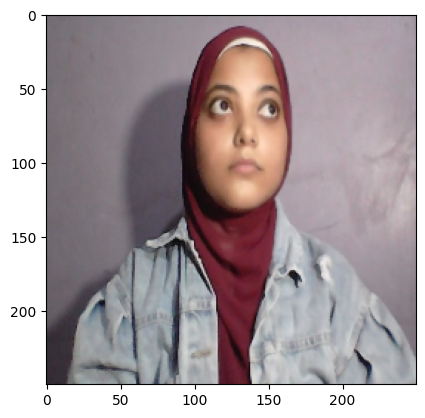

In [72]:
plt.imshow(img)

In [73]:
#data labelling
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip ((anchor, positive, tf.data.Dataset.from_tensor_slices (tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip ((anchor, negative, tf.data.Dataset.from_tensor_slices (tf.zeros(len (anchor)))))
data = positives.concatenate (negatives)

In [74]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [75]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [1]:
samples = data.as_numpy_iterator()
samples.next()

NameError: name 'data' is not defined